In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

import pytorch_lightning as pl
from torchmetrics import MetricCollection, Accuracy, F1Score

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from ptflash.doe import DOE
from ptflash.utils import get_properties
from ptflash.equilibrium import PTVLE
from ptflash.networks import PTNet, TrainWrapper

/work/home/.conda/envs/mypytorchenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/work/home/.conda/envs/mypytorchenv/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /work/home/.conda/envs/mypytorchenv/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefINS2_6SymIntEEENS2_8optionalINS2_10ScalarTypeEEENS6_INS2_6LayoutEEENS6_INS2_6DeviceEEENS6_IbEENS6_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
torch.set_default_dtype(torch.float32)
seed = 123

## Generate data

In [3]:
# CH4, C2H6, C3H8, C4H10, C5H12, C6H14, C7H16, CO2, N2
components = [74828, 112403]
n_components = len(components)
conditions = {"pmin": 5.0e6, "pmax": 2.5e7, "tmin": 200, "tmax": 600}

n_samples = 1000000
doe = DOE(
    n_samples,
    n_components,
    pmin=conditions["pmin"],
    pmax=conditions["pmax"],
    tmin=conditions["tmin"],
    tmax=conditions["tmax"],
    doe_type="dirichlet",
    random_state=seed,
)
design = doe.create_design()

In [4]:
dtype = torch.float64
device = "cpu"
pcs, tcs, omegas, kij, kijt, kijt2 = get_properties(components, dtype, device)
ptvle = PTVLE(
    pcs,
    tcs,
    omegas,
    kij,
    kijt,
    kijt2,
    dtype=dtype,
    cubic_solver="halley",
    device=device,
)
inputs = torch.tensor(design.to_numpy(), dtype=dtype, device=device)
unstable, theta_v, xi, yi, ki = ptvle(
    inputs, sa_max_nit1=9, sa_max_nit2=40, split_max_nit1=9, split_max_nit2=40
)

# Prepare data for training

## Set inputs $X$ and target $y$

In [5]:
X = torch.from_numpy(design.to_numpy())
# classifier is used to predict stability
y = (~unstable).double().reshape(-1, 1)
X = X.type(torch.FloatTensor)
y = y.type(torch.FloatTensor)
print(X.type())
print(y.type())

torch.FloatTensor
torch.FloatTensor


## Split data into training, validation and test

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=seed
)

## Create data loaders

In [7]:
train_ds = TensorDataset(X_train, y_train)
valid_ds = TensorDataset(X_valid, y_valid)
test_ds = TensorDataset(X_test, y_test)

In [8]:
batch_size = 512
workers = 4
train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers,
    pin_memory=True,
)
valid_loader = DataLoader(
    valid_ds, batch_size=batch_size, num_workers=workers, pin_memory=True
)
test_loader = DataLoader(
    test_ds, batch_size=batch_size, num_workers=workers, pin_memory=True
)


# Network

In [9]:
pl.seed_everything(seed)

Global seed set to 123


123

In [10]:
net = PTNet(
    input_dim=X_train.shape[1],
    output_dim=1,
    mean=X_train.mean(dim=0),
    scale=X_train.std(dim=0),
    units=(32, 32, 32),
    activation="SiLU",
)

## Find a good learning rate

In [11]:
trainer = pl.Trainer(
        #accelerator=None if torch.cuda.is_available() else None, logger=False
        accelerator="cpu" #if torch.cuda.is_available() else None, logger=False
)
tuner = pl.tuner.Tuner(trainer)

finder = tuner.lr_find(
    TrainWrapper(net, nn.BCEWithLogitsLoss()),
    train_loader,
    valid_loader,
    min_lr=1e-6,
    max_lr=0.1,
    num_training=len(train_loader),
)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/work/home/.conda/envs/mypytorchenv/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/work/home/.conda/envs/mypytorchenv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
/work/home/.

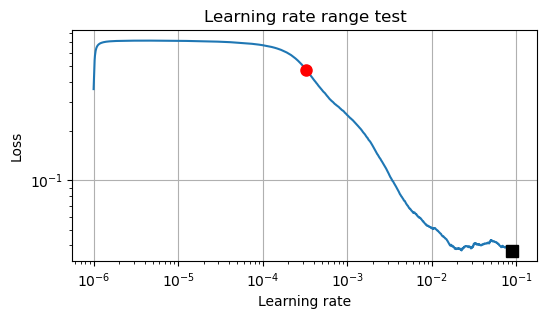

In [12]:
suggestion = finder.suggestion()
lr = np.array(finder.results["lr"])
loss = np.array(finder.results["loss"])
plt.figure(figsize=(6, 3))
plt.plot(lr, loss)
plt.plot(
    suggestion, loss[lr == suggestion], markersize=8, marker="o", color="red"
)
plt.plot(lr[loss.argmin()], loss.min(), markersize=8, marker="s", color="black")
plt.title("Learning rate range test")
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.xscale("log")
plt.yscale("log")
plt.grid(True)
plt.show()

## Training

In [13]:
wrapper = TrainWrapper(
    net,
    loss_func=nn.BCEWithLogitsLoss(),
    metrics=MetricCollection([Accuracy(task="binary"), F1Score(task="binary")]),
    sche_args=dict(
        base_lr=1e-4,
        max_lr=0.01,
        step_size_up=2 * len(train_loader),
        mode="triangular2",
        cycle_momentum=False,
    ),
)


In [14]:
trainer = pl.Trainer(
    logger=False, accelerator="cpu", max_epochs=10, enable_checkpointing=False
)


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(wrapper, train_dataloaders=train_loader, val_dataloaders=valid_loader)


  | Name          | Type              | Params
----------------------------------------------------
0 | net           | PTNet             | 2.3 K 
1 | loss_func     | BCEWithLogitsLoss | 0     
2 | metrics       | MetricCollection  | 0     
3 | train_metrics | MetricCollection  | 0     
4 | valid_metrics | MetricCollection  | 0     
5 | test_metrics  | MetricCollection  | 0     
----------------------------------------------------
2.3 K     Trainable params
8         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 1250/1250 [01:26<00:00, 14.47it/s, train_BinaryAccuracy=0.994, train_BinaryF1Score=0.996]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 1250/1250 [01:16<00:00, 16.31it/s, train_BinaryAccuracy=0.986, train_BinaryF1Score=0.992, valid_loss=0.0216, val_BinaryAccuracy=0.991, val_BinaryF1Score=0.994]
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 1250/1250 [01:22<00:00, 15.11it/s, train_BinaryAccuracy=0.996, train_BinaryF1Score=0.998, valid_loss=0.0222, val_BinaryAccuracy=0.990, val_BinaryF1Score=0.994]
Validation: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 1250/1250 [01:24<00:00, 14.73it/s, train_BinaryAccuracy=0.998, train_BinaryF1Score=0.999, valid_loss=0.00978, val_BinaryAccuracy=0.996, val_BinaryF1Score=0.997]
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 1250/1250 [01:22<00:00, 15.19it/s, train_BinaryAccuracy=0.994, train_BinaryF1Score=0.996, valid_loss=0.00443, val_BinaryAccuracy=0.998, val_BinaryF1Score=0.999]
Validation: 0i

## Test

In [ ]:
test_res = trainer.test(wrapper, test_loader)

# Save the model

In [ ]:
torch.save(net, "ptflash_NoNN_classifier_2comp_float_CH4_C6H14.pt")

import torch.onnx
import torchvision

#batch_size = 512

#initializer = torch.load("initializer.pt")
#initializer.eval()
net.eval()
torch.onnx.export(net,               # model being run
                  X,                         # model input (or a tuple for multiple inputs)
                  "ptflash_NoNN_classifier_2comp_float_CH4_C6H14.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['inputs'],   # the model's input names
                  output_names = ['ki'], # the model's output names
                  dynamic_axes={'inputs' : {0 : 'batch_size'}})    # variable length axes
                   #             'output' : {0 : 1}})

In [29]:
loadnet = torch.load("classifier_2comp.pt")
#loadnet.float
loadnet.eval()

torch.onnx.export(loadnet,               # model being run
                  X,                         # model input (or a tuple for multiple inputs)
                  "ptflash_NoNN_classifier_2comp_float_CH4_C6H14.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['inputs'],   # the model's input names
                  output_names = ['ki'], # the model's output names
                  dynamic_axes={'inputs' : {0 : 'batch_size'}})    # variable length axes
                   #             'output' : {0 : 1}})


In [19]:
import onnx

# Load the ONNX model
check_model = onnx.load("ptflash_NoNN_classifier_2comp_float_CH4_C6H14.onnx")

#check_model.to(float)

# Check that the IR is well formed
onnx.checker.check_model(check_model)

# Print a human readable representation of the graph
onnx.helper.printable_graph(check_model.graph)

'graph torch_jit (\n  %inputs[FLOAT, batch_sizex4]\n) initializers (\n  %mean[FLOAT, 4]\n  %scale[FLOAT, 4]\n  %trunk.0.weight[FLOAT, 32x4]\n  %trunk.0.bias[FLOAT, 32]\n  %trunk.2.weight[FLOAT, 32x32]\n  %trunk.2.bias[FLOAT, 32]\n  %trunk.4.weight[FLOAT, 32x32]\n  %trunk.4.bias[FLOAT, 32]\n  %out_layer.weight[FLOAT, 1x32]\n  %out_layer.bias[FLOAT, 1]\n) {\n  %onnx::Div_11 = Sub(%inputs, %mean)\n  %onnx::Gemm_12 = Div(%onnx::Div_11, %scale)\n  %input = Gemm[alpha = 1, beta = 1, transB = 1](%onnx::Gemm_12, %trunk.0.weight, %trunk.0.bias)\n  %onnx::Mul_14 = Sigmoid(%input)\n  %onnx::Gemm_15 = Mul(%input, %onnx::Mul_14)\n  %input.3 = Gemm[alpha = 1, beta = 1, transB = 1](%onnx::Gemm_15, %trunk.2.weight, %trunk.2.bias)\n  %onnx::Mul_17 = Sigmoid(%input.3)\n  %onnx::Gemm_18 = Mul(%input.3, %onnx::Mul_17)\n  %input.7 = Gemm[alpha = 1, beta = 1, transB = 1](%onnx::Gemm_18, %trunk.4.weight, %trunk.4.bias)\n  %onnx::Mul_20 = Sigmoid(%input.7)\n  %onnx::Gemm_21 = Mul(%input.7, %onnx::Mul_20)\n  %